<a href="https://colab.research.google.com/github/MSunaam/Dip-Project/blob/main/Copy_of_cropsDiseaseClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import datetime


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [80]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# defines the number of processes that loads the data, idealy set according to the number of the cores available in cpu
NUM_WORKERS = min(4, os.cpu_count()) if DEVICE == "cpu" else 2
BATCH_SIZE = 16;
IMAGE_SIZE = 224
PATH = "/content/drive/MyDrive/CCMT_FInal Dataset";
# PATH="/content/drive/MyDrive/Test-Dataset";
TRAIN_RATIO = 0.95
layersToTrain = 10;


In [81]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    ])

full_dataset = datasets.ImageFolder(root=PATH, transform=transform)

In [82]:
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers = NUM_WORKERS)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers = NUM_WORKERS)

In [83]:
num_classes = len(full_dataset.classes)

In [84]:
resnet = models.resnet50(pretrained=True)

resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [85]:
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [86]:
#loading model states from a checkpoint
resnet = resnet.to(DEVICE)
checkpoint = torch.load('/content/drive/MyDrive/cropsClassifierCheckpoints/checkpoint_11_epoch_lr=0.000001_2.pth',map_location=torch.device(DEVICE
                                                                                                                           ));
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [87]:
layersForTraining = list(resnet.children())[-layersToTrain:]

# Set requires_grad to True for the parameters of the identified layers
for layer in layersForTraining:
    for param in layer.parameters():
        param.requires_grad = True


In [88]:
total_parameters = len(list(resnet.parameters()))
total_layers = len(list(resnet.children()))
print(f"Total Parameters {total_parameters}\n",f"Total Layers {total_layers}")

Total Parameters 161
 Total Layers 10


In [89]:
# these structures maintain the stats for whole epoch

critValidationLoss = [];
critTrainingLoss = [];

# for misclassification stats

clsfValidationLoss = [];
clsfTrainingLoss = [];

clsfValidationBatch = []

epochIters = []
print(f'device {DEVICE} , num_workers {NUM_WORKERS}' )

device cpu , num_workers 2


In [90]:
# these lists maintain the stats for a batch

lossCriterionList = [0];
lossMisclassificationList = [0]
bIters = [0];

In [91]:
bIters[-1]

0

In [92]:
def calculateMisclassificationPercentage(logits, labels):
    """
    Calculate the percentage of misclassification given logits and truth labels.

    Parameters:
        logits (torch.Tensor): The predicted logits.
        labels (torch.Tensor): The ground truth labels.

    Returns:
        float: The percentage of misclassification.
    """
    _, predicted_indices = torch.max(logits, 1)
    _, label_indices = torch.max(labels, 1)

    correct = (predicted_indices == label_indices).sum().item()
    total = label_indices.size(0)

    return ((1 - (correct / total)) * 100)


In [93]:
checkpoint_dir = '/content/drive/MyDrive/cropsClassifierCheckpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [94]:
def fgsm_attack(image, epsilon, gradient):
  gradient_sign = gradient.sign()
  perturbed_image = image + epsilon*gradient_sign
  return torch.clamp(perturbed_image,0,1)

In [100]:
#testing on some images
image = Image.open("/content/drive/MyDrive/CCMT_FInal Dataset/Maize_healthy/healthy37_.jpg")

transformToTorch = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tensorImage = transformToTorch(image).to(DEVICE, dtype=torch.float32)

tensorImage = tensorImage.to(DEVICE,dtype=torch.float32); # shifting it to the gpu if available and converting type to float 32
batchImage = tensorImage.unsqueeze(0); # adding the dimension for batch;
batchImage.requires_grad = True

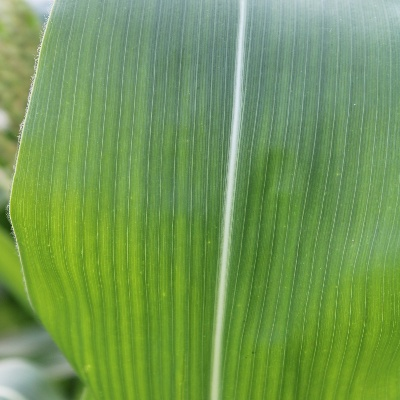

In [103]:
image

In [117]:
resnet.to(DEVICE)

truth_tensor = torch.zeros([1], dtype=torch.long)
index_to_set = 12
truth_tensor[0] = index_to_set

#switching to the evaluation mode no gradients graphs computed
resnet.eval()

output = resnet(batchImage)
resnet.zero_grad()

loss = criterion(output, truth_tensor)
loss.backward()

gradients = batchImage.grad

confidenceTensor = torch.nn.Softmax(dim=1)(output).data
maxProbIdx = torch.argmax(confidenceTensor,dim=1)

print(f"Output Label {full_dataset.classes[maxProbIdx]}\nConfidence Level {(confidenceTensor.tolist())[0][maxProbIdx]*100}%\nLoss {loss}")

perturbed_image = fgsm_attack(batchImage,0.005, gradients)

attack_image=perturbed_image.squeeze(0)
tensor_to_pil = transforms.ToPILImage()(attack_image)

output = resnet(perturbed_image)
confidenceTensor = torch.nn.Softmax(dim=1)(output).data
maxProbIdx = torch.argmax(confidenceTensor,dim=1)

print(f"Output Label {full_dataset.classes[maxProbIdx]}\nConfidence Level {(confidenceTensor.tolist())[0][maxProbIdx]*100}%")


Output Label Maize_healthy
Confidence Level 77.2863507270813%
Loss 0.25765281915664673
Output Label Maize_leaf spot
Confidence Level 63.61469626426697%


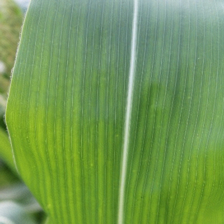

In [118]:
tensor_to_pil